In [1]:
import os
import sys

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from collections import defaultdict

In [3]:
package_root = os.path.abspath('../../..')
if package_root not in sys.path:
    sys.path.append(package_root)
from seismic.ASDFdatabase import FederatedASDFDataSet

In [4]:
import obspy
from analytic_plot_utils import distance
from netCDF4 import Dataset as NCDataset

In [5]:
# Imports for plotting
from textwrap import wrap
from scipy import signal

In [6]:
ds = FederatedASDFDataSet.FederatedASDFDataSet("/g/data/ha3/Passive/SHARED_DATA/Index/asdf_files.txt")

Found database: /g/data/ha3/Passive/SHARED_DATA/Index/c120284bcf4931e639eecf4e026f6ccfaf7b6306.db


In [7]:
SRC_FILE = "/g/data/ha3/am7399/shared/xcorr/AU/ARMA_CMSA/AU.ARMA.AU.CMSA.nc"

In [8]:
TIME_WINDOW = 300 # +/-
SNR_THRESHOLD = 10

In [9]:
# Read xcorr data
xcdata = NCDataset(SRC_FILE, 'r')
print(xcdata)

xc_start_times = xcdata.variables['IntervalStartTimes'][:] # sTimes
xc_end_times = xcdata.variables['IntervalEndTimes'][:] # eTimes
xc_lag = xcdata.variables['lag'][:] # lag
xc_xcorr = xcdata.variables['xcorr'][:, :] # xcorr
xc_nStackedWindows = xcdata.variables['NumStackedWindows'][:] # nStackedWindows
xcdata.close()
xcdata = None

start_utc_time = obspy.UTCDateTime(xc_start_times[0])
end_utc_time = obspy.UTCDateTime(xc_end_times[-1])
print((start_utc_time, end_utc_time))

<type 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    description: Cross-correlation results for station-pair: AU.ARMA.AU.CMSA
    dimensions(sizes): lag(287999), interval(580)
    variables(dimensions): float32 lag(lag), float32 interval(interval), float32 NumStackedWindows(interval), int64 IntervalStartTimes(interval), int64 IntervalEndTimes(interval), float32 xcorr(interval,lag)
    groups: 

(UTCDateTime(2005, 1, 1, 0, 0), UTCDateTime(2007, 1, 1, 0, 0))


In [10]:
start_time = str(start_utc_time)
end_time = str(end_utc_time)
print((start_time, end_time))

('2005-01-01T00:00:00.000000Z', '2007-01-01T00:00:00.000000Z')


In [11]:
# Get station codes from file name
def stationCodes(filename):
    path, fname = os.path.split(filename)
    parts = fname.split('.')
    sta1 = '.'.join(parts[0:2])
    sta2 = '.'.join(parts[2:4])
    return (sta1, sta2)

In [12]:
def stationCoords(federated_ds, code, datetime):
    ds = federated_ds
    net, sta = code.split('.')
    sta_records = ds.get_stations(datetime, obspy.UTCDateTime(datetime) + 3600, network=net, station=sta)
    z_records = [r for r in sta_records if r[3][1:3] == 'HZ']
    assert len(z_records) == 1
    z_record = z_records[0]
    return z_record[4:6]

In [13]:
def stationDistance(federated_ds, code1, code2, datetime):
    coords1 = stationCoords(federated_ds, code1, datetime)
    coords2 = stationCoords(federated_ds, code2, datetime)
    return distance(coords1, coords2)

In [14]:
origin_code, dest_code = stationCodes(SRC_FILE)

In [15]:
stationCoords(ds, origin_code, start_time)

[151.628, -30.4198]

In [16]:
stationCoords(ds, dest_code, start_time)

[145.6916, -31.5375]

In [17]:
dist = stationDistance(ds, origin_code, dest_code, start_time)
print(dist)

668.561890953


In [18]:
def debugLabelAxes(ax, label):
    ax.text(0.5, 0.95, label, horizontalalignment='center', verticalalignment='top', transform=ax.transAxes, fontsize=20)

In [19]:
def plotXcorrTimeseries(ax):
    pass

In [20]:
lagIndices = np.squeeze(np.argwhere(np.fabs(np.round(xc_lag, decimals=2)) == TIME_WINDOW))
sTimes = xc_start_times
lag = xc_lag[lagIndices[0]:lagIndices[1]]
ccf = xc_xcorr[:, lagIndices[0]:lagIndices[1]]
nsw = xc_nStackedWindows


In [22]:
# plt.figure(figsize=(16,9))
# plt.plot(t, g)
# plt.plot(t, [np.mean(g)]*len(t))
# plt.plot(t, [np.mean(g) + 2*np.std(g)]*len(t), ':')
# plt.plot(t, (g > (np.mean(g) + 2*np.std(g)))*np.max(g), '--', alpha=0.5)

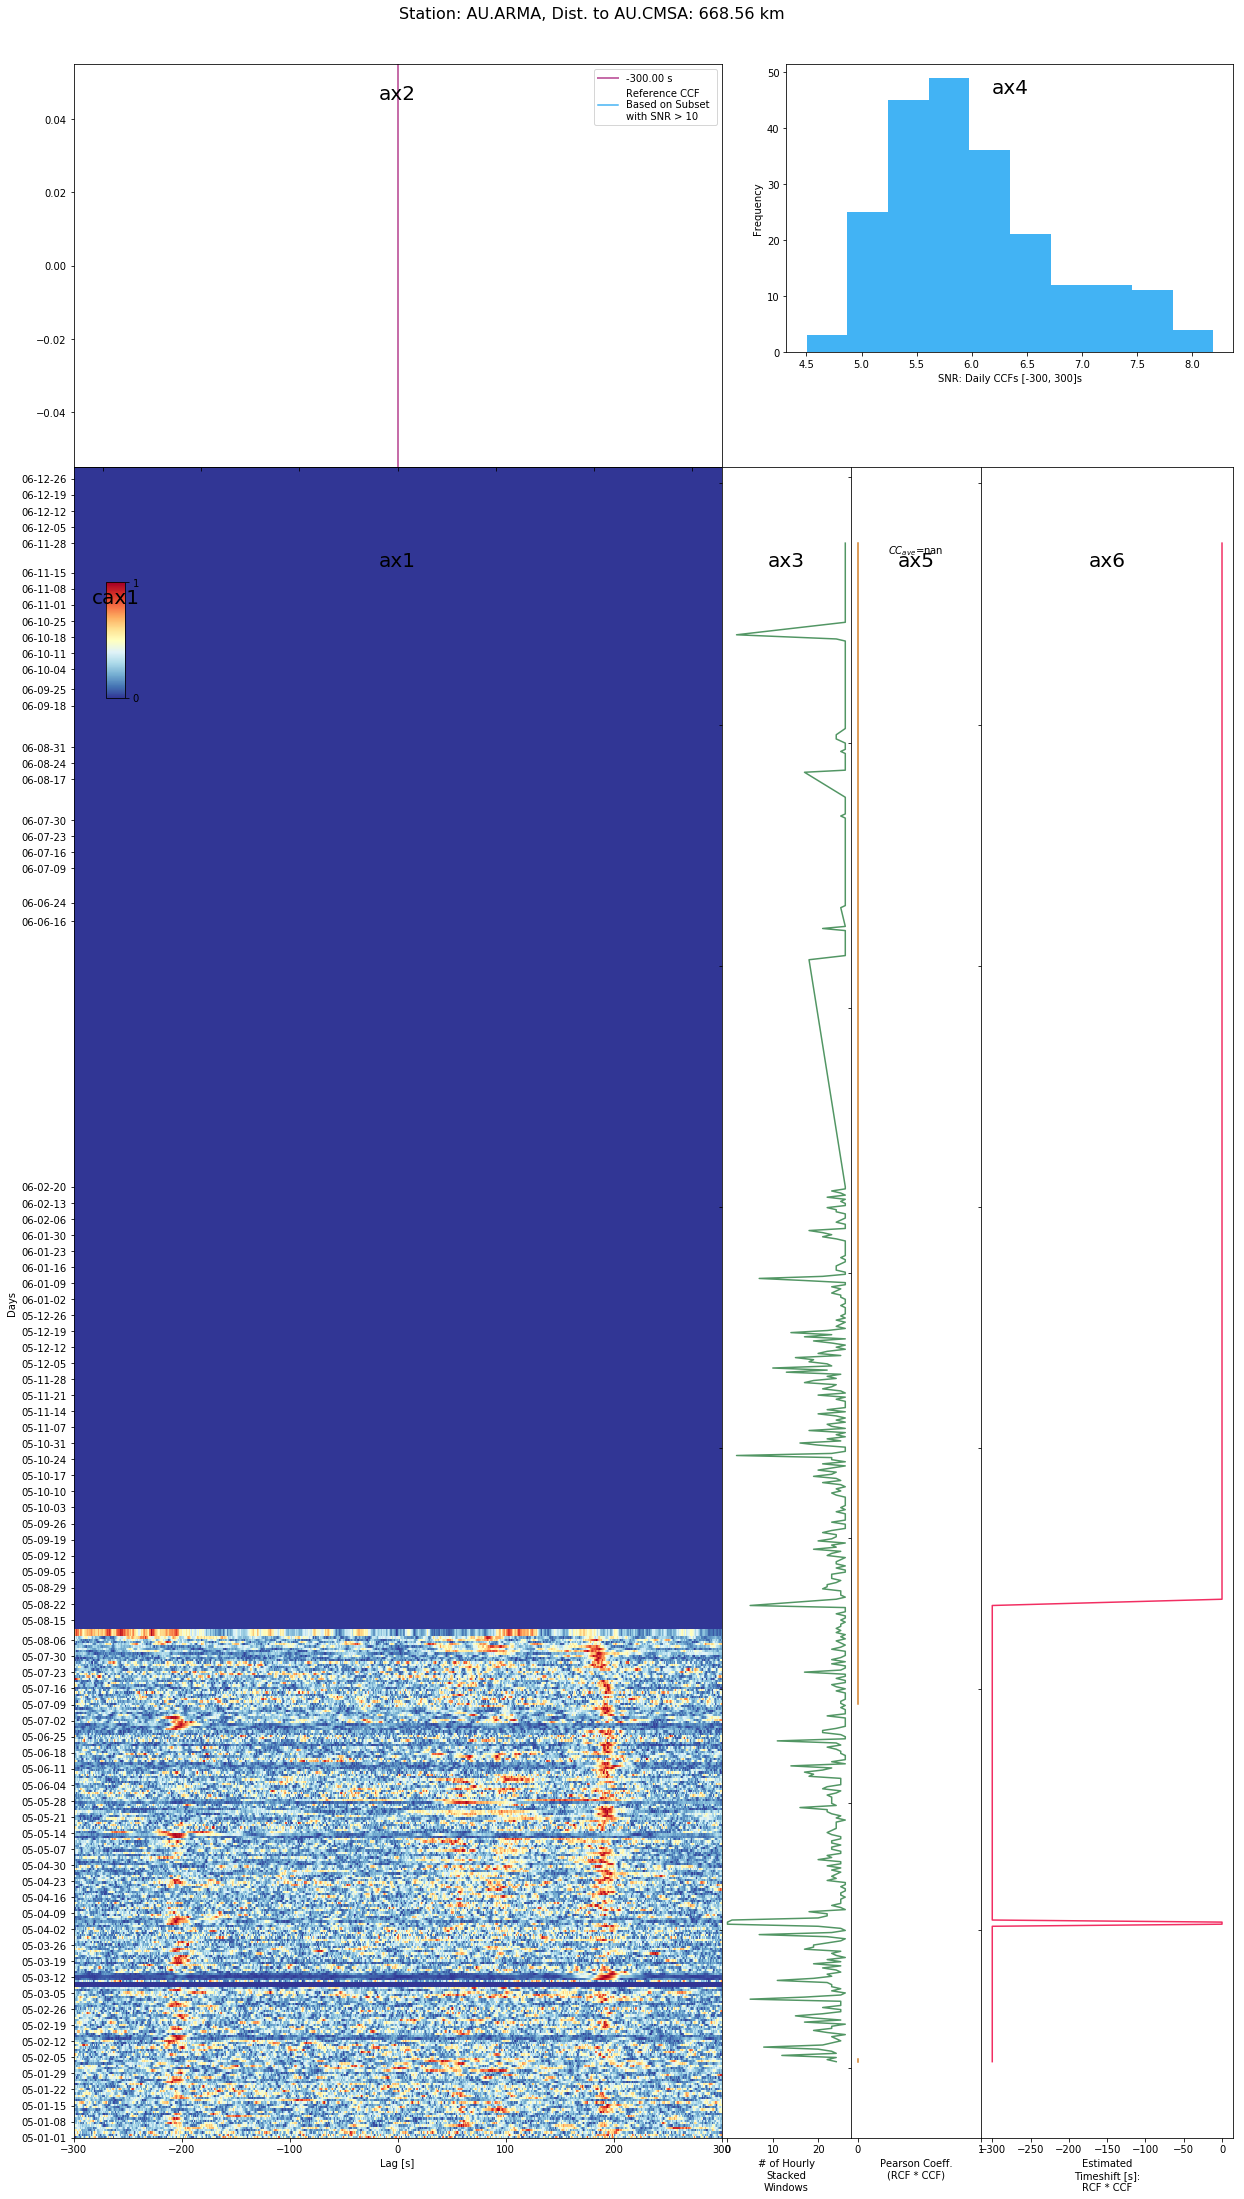

In [23]:
fig = plt.figure(figsize=(18,32))
fig.suptitle("Station: {}, Dist. to {}: {:3.2f} km".format(origin_code, dest_code, dist), fontsize = 16, y=1)

ax1 = fig.add_axes([0.1, 0.075, 0.5, 0.725])
debugLabelAxes(ax1, 'ax1')
cax1 = fig.add_axes([0.125, 0.7, 0.015, 0.05])
debugLabelAxes(cax1, 'cax1')

labelPad = 0.05
ax2 = fig.add_axes([0.1, 0.8, 0.5, 0.175])
ax3 = fig.add_axes([0.6, 0.075, 0.1, 0.725]) # stacked windows
ax4 = fig.add_axes([0.6 + labelPad, 0.8 + labelPad, 0.345, 0.175 - labelPad]) # histogram
ax5 = fig.add_axes([0.7, 0.075, 0.1, 0.725]) # C3
ax6 = fig.add_axes([0.8, 0.075, 0.195, 0.725]) # timeshifts
debugLabelAxes(ax2, 'ax2')
debugLabelAxes(ax3, 'ax3')
debugLabelAxes(ax4, 'ax4')
debugLabelAxes(ax5, 'ax5')
debugLabelAxes(ax6, 'ax6')

# Plot CCF image =======================
gx, gy = np.meshgrid(lag, sTimes)
im = ax1.pcolormesh(gx, gy, ccf, cmap='RdYlBu_r', vmin=0, vmax=1, rasterized=True)

t = np.array(sTimes)

# g = np.gradient(t)
# indices = np.argwhere(g > (np.mean(g) + 2*np.std(g)))
# if len(indices) > 1:
# #     from descartes import PolygonPatch
#     for i, idx in enumerate(indices[::2]):
#         bx = np.array([np.min(gx), np.max(gx), np.max(gx), np.min(gx), np.min(gx)])
#         by = np.array([sTimes[idx], sTimes[idx], sTimes[indices[i+1]], sTimes[indices[i+1]], sTimes[idx]])

#         xy = zip(bx,by)
#         poly = Polygon(xy)
# #         ax1.add_patch(PolygonPatch(poly, facecolor='white', ec='red'))
#     # end for
# # end if

labels=[]
for st in sTimes: 
    labels.append(obspy.UTCDateTime(st).strftime("%y-%m-%d"))
ax1.set_yticks(sTimes[::7])
ax1.set_yticklabels(labels[::7])
ax1.set_xlabel('Lag [s]')
ax1.set_ylabel('Days')

fig.colorbar(im, cax=cax1, orientation='vertical', ticks=[0, 1])

# Plot CCF-template =====================
rowMask = (np.sum(ccf, axis=1)>0)
mask = np.ones_like(ccf)
for i in range(len(rowMask)):
    mask[i,:] *= rowMask[i] 

ccfMasked = np.ma.masked_array(ccf, mask=~np.bool_(mask))
snr = np.nanmax(ccfMasked, axis=1) / np.nanstd(ccfMasked, axis=1)    

rcf = np.nanmean(ccfMasked[snr>SNR_THRESHOLD, :], axis=0)
ax2.axvline(lag[np.argmax(rcf)], c='#c66da9', lw=2,
            label = '%5.2f s'%(lag[np.argmax(rcf)]))
ax2.plot(lag, rcf, c='#42b3f4', 
         label=r"Reference CCF "
                "\n"
                "Based on Subset "
                "\n"
                "with SNR > %d"%SNR_THRESHOLD)
ax2.set_xticklabels([])
ax2.legend()

# Plot number of stacked windows ==============
ax3.plot(nsw, sTimes, c='#529664')
ax3.set_yticklabels([])
ax3.set_xlabel('\n'.join(wrap('# of Hourly Stacked Windows', 12)))
xtl = ax3.get_xticklabels()
xtl[0].set_visible(False)
xtl[-1].set_visible(False)

# Plot histogram
ax4.hist(snr.compressed(), fc='#42b3f4', ec='none', bins=10)
ax4.set_xlabel('SNR: Daily CCFs [-%d, %d]s'%(TIME_WINDOW, TIME_WINDOW))
ax4.set_ylabel('Frequency')
xtl = ax4.get_xticklabels()
xtl[0].set_visible(False)
xtl[-1].set_visible(False)

# plot cc ===================
# Compute CCave
cc = []
for row in ccfMasked:
    if(np.ma.is_masked(row)): 
        cc.append(0)
        continue

    pcf, _ = scipy.stats.pearsonr(rcf, row)
    cc.append(pcf)
# end for
cc = np.array(cc)
ccav = np.mean(np.ma.masked_array(cc, mask=cc==0))

ax5.plot(cc, sTimes, c='#d37f26')
ax5.set_yticklabels([])
ax5.set_xticks([0,1])
ax5.set_xlabel('\n'.join(wrap('Pearson Coeff. (RCF * CCF)', 15)))
ax5.text(0.5, 0.95, '$CC_{ave}$=%3.3f'%ccav, horizontalalignment='center', \
         verticalalignment='center', transform=ax5.transAxes)

# plot Timeshift =====================    
corr = []
for i, row in enumerate(ccfMasked):
    if(np.ma.is_masked(row)): 
        corr.append(0)
        continue

    if(cc[i] < 0.85*ccav):
        corr.append(0)
        continue

    c3 = scipy.signal.correlate(rcf, row, mode='same')
    c3 /= np.max(c3)
    corr_lag = lag[np.argmax(c3)]
    corr.append(corr_lag)    
# end for
corr = np.array(corr)
ax6.plot(corr, sTimes, c='#f22e62', lw=1.5)
ax6.set_yticklabels([])
xtl = ax6.get_xticklabels()
xtl[0].set_visible(False)
xtl[-1].set_visible(False)
ax6.set_xlabel('\n'.join(wrap('Estimated Timeshift [s]: RCF * CCF', 15)))

plt.show()
plt.close()